In [2]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import xarray as xr 
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm

import global_gauges as gg

target_crs = "EPSG:4326"

datasets = Path("/nas/cee-water/cjgleason/data")
proj_root = Path("/nas/cee-water/cjgleason/ted/swot-ml")

data_dir = proj_root / 'data' / 'reservoirs' 
metadata_dir = data_dir / 'metadata'
metadata_dir.mkdir(parents=True, exist_ok=True)

attributes_dir = data_dir / 'attributes'
attributes_dir.mkdir(parents=True, exist_ok=True)

fig_dir = data_dir / '_figures'
fig_dir.mkdir(parents=True, exist_ok=True)

basin = 'Ohio'
# basin = 'Upper_Miss'
# basin = 'Missouri'


# Read graph JSON
with open(metadata_dir / f'{basin}_graph.json') as f:
    graph_json = json.load(f)
G = nx.readwrite.json_graph.node_link_graph(graph_json, edges='edges')

basins = gpd.read_file(metadata_dir / f'{basin}_basins.geojson').set_index('comid')
basins['outlet'] = [Point(xy) for xy in zip(basins['lng'], basins['lat'])]
basin_geom = basins.geometry.union_all()

outlets = basins.copy()
outlets = outlets.set_geometry('outlet').set_crs('EPSG:4326')



In [14]:
facade = gg.GaugeDataFacade(providers='usgs')
sites = facade.get_stations_n_days(90)

<Axes: >

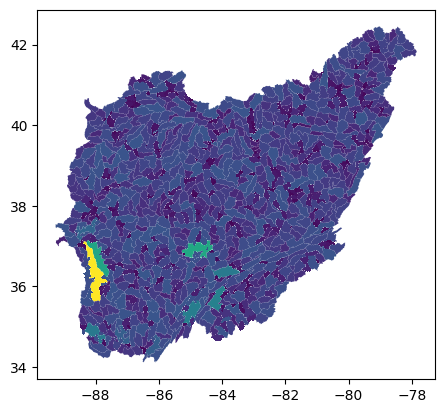

In [3]:
basins.plot('unitarea')

In [4]:
print("reading SWORD")
sword_dir =  datasets / 'SWORD' / 'SWORDv17' / 'shp'
sword_files = list(sword_dir.glob('*/*reaches*.shp'))
sword = pd.concat([gpd.read_file(f) for f in tqdm(sword_files)])

sword = sword.to_crs(target_crs).clip(basin_geom)
sword['type'] = sword['reach_id']%10
sword = sword.rename(columns={'facc':'sword_area'})

# Get subset of rivers and lakes on rivers
basin_sword = sword[sword['type'].isin([1,3])]

reading SWORD


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


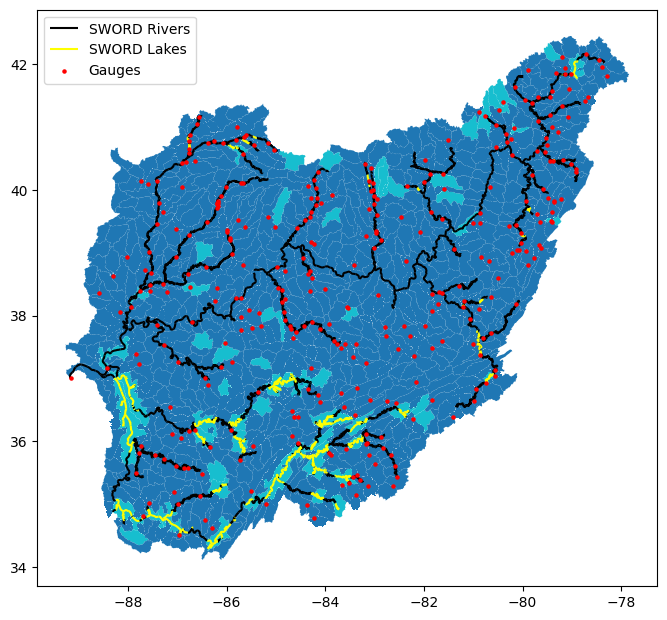

In [5]:
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))

basins.plot('reservoir', categorical=True, ax=ax)
basin_sword[basin_sword['type']==1].plot(color='black', ax=ax, label='SWORD Rivers')
basin_sword[basin_sword['type']==3].plot(color='yellow', ax=ax, label='SWORD Lakes')
outlets[outlets['custom']].plot(ax=ax, color='red', markersize=5, zorder=10, label='Gauges')
plt.legend()

fig.savefig(fig_dir / f'all_data_{basin}.png', dpi=300)

In [8]:
matchups = basins.reset_index()[['comid','reservoir','custom','total_area','unitarea','dist_downstream','outlet','geometry']]

matchups = gpd.sjoin_nearest(
    matchups.to_crs("EPSG:6933"),
    basin_sword[['reach_id', 'type', 'sword_area', 'geometry']].to_crs("EPSG:6933"),
    how='left',
    max_distance=1000,
    distance_col='sword_distance')
matchups.drop(columns='index_right', inplace=True)

matchups = matchups.to_crs('epsg:4326').reset_index(drop=True)

In [11]:
sword_pfaf2 = (matchups['reach_id'] // 1E9).dropna().unique()

if len(sword_pfaf2) != 1:
    print("Not implemented for multiple Pfaf2 basins at a time.")
else:
    ms_path = datasets/"MERIT-SWORD"/"ms_translate"/"sword_to_mb"
    mb_ds = xr.open_dataset(ms_path / f"sword_to_mb_pfaf_{int(sword_pfaf2[0])}_translate.nc")

    # Load in PLD data
    stem = f"SWOT_L2_HR_LakeAvg_024_NA_{int(sword_pfaf2[0])}_20241112T025038_20241202T233543_PIC2_01.shp"
    filepath = datasets / 'PLD' / 'SWOT_L2_HR_LAKEAVG' / stem
    pld = gpd.read_file(filepath).replace({'no_data': None}).dropna(subset='reach_id')

    pld['reach_id'] = pld["reach_id"].apply(
        lambda x: x.split(";") if isinstance(x, str) and x.strip() else []
    )
    pld = pld.explode('reach_id')
    

In [10]:
grp_cols = ['geometry','outlet','total_area','unitarea','reservoir','custom']
sword_r_cols = ['reach_id','sword_area','sword_distance']
sword_l_cols = ['lake_reach_ids', 'lake_pld_ids']
all_columns = grp_cols + sword_r_cols + sword_l_cols

mb_vars = [var for var in mb_ds.data_vars if var.startswith("mb_")]

def get_best_pair(grp):
    data_dict = {k: np.nan for k in all_columns}
    data_dict.update(grp.iloc[0][grp_cols].to_dict())

    # SWORD river reach matching.
    # Pick best match by area with a limit of 30% difference.
    rivers = grp[grp['type']==1]
    if len(rivers)>0:
        sword_area_diff = (grp['sword_area'] - grp['total_area']) / (grp[['sword_area','total_area']].mean(axis=1))
        if any(sword_area_diff.abs() < 0.3):
            idx_min = sword_area_diff.abs().idxmin()
            data_dict.update(grp.loc[idx_min][sword_r_cols].to_dict())

    # Get all SWORD lake reaches in the subbasin
    sword_lakes = grp[grp['type']==3]
    sword_lake_ids =  sword_lakes['reach_id'].astype(int).to_list()
    data_dict['lake_reach_ids'] = sword_lake_ids

    pld_ix = pld[pld['reach_id'].astype(int).isin(sword_lake_ids)]
    pld_ids = pld_ix['lake_id'].astype(int).to_list()
    data_dict['lake_pld_ids'] = list(set(pld_ids))

    # Get all MERIT basin ids corresponding to SWORD reaches
    sword_ids = grp['reach_id'].dropna().astype(int).unique()
    mb_vals = []
    for sid in sword_ids:
        if sid in mb_ds['sword']:
            mbvs = [mb_ds[var].sel(sword=sid).item() for var in mb_vars]
            mbvs = [mb for mb in mbvs if mb != 0] # trim 0s 
            mb_vals.extend(mbvs)
    data_dict['mb_values'] = mb_vals 

    return pd.Series(data_dict)
        
matchups_clean = matchups.groupby('comid').apply(get_best_pair, include_groups=False)
matchups_clean.set_crs('epsg:4326', inplace=True)

,geometry,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,mb_values
comid,,,,,,,,,,,,
74024610,"MULTIPOLYGON (((-78.87292 41.76875, -78.87292 ...",POINT (-78.8742 41.77),4837.3,674.0,False,False,7.426990e+10,4519.811622,0.0,[],[],"[74029162, 74029163, 74029163, 74029168]"
74024620,"POLYGON ((-78.59792 41.86125, -78.59708 41.861...",POINT (-78.6258 41.9842),3738.3,715.2,False,False,7.426990e+10,3764.503644,0.0,[],[],"[74029170, 74029172, 74029169, 74029168, 74029..."
74024945,"POLYGON ((-78.15292 41.88125, -78.15292 41.882...",POINT (-78.3933 41.9758),2262.2,725.1,False,False,NaN,NaN,NaN,[],[],"[74029175, 74029173, 74029179, 74029172]"
74025163,"POLYGON ((-79.20958 42.28458, -79.21125 42.284...",POINT (-79.1067 42.13),892.3,892.1,False,False,NaN,NaN,NaN,[],[],[]
74025192,"POLYGON ((-79.15875 42.15042, -79.15792 42.150...",POINT (-79.1817 42.1308),1010.5,500.4,False,False,NaN,NaN,NaN,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-03601990,"POLYGON ((-87.47708 35.52208, -87.47958 35.522...",POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],[],"[74058746, 74058745, 74058745, 74058744, 74058..."
USGS-03603000,"POLYGON ((-87.74375 35.92292, -87.74375 35.926...",POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],[],"[74058738, 74058737, 74058739, 74056179, 74058..."
USGS-03604000,"POLYGON ((-87.80958 35.41458, -87.81042 35.414...",POINT (-87.8333 35.4958),1156.4,538.5,False,True,7.426220e+10,1106.467116,0.0,[],[],"[74058775, 74058778, 74058773, 74058773]"


In [15]:
site_cols = [
    'name','area','latitude','longitude',
    'min_date','max_date',
    'min_discharge','max_discharge','mean_discharge',
    'count_discharge','provider'
]

matchups_sites = matchups_clean.merge(
    sites[site_cols], 
    left_index=True, 
    right_index=True, 
    how='left'
)

In [16]:
matchups_sites

,geometry,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,...,area,latitude,longitude,min_date,max_date,min_discharge,max_discharge,mean_discharge,count_discharge,provider
comid,,,,,,,,,,,,,,,,,,,,,
74024610,"MULTIPOLYGON (((-78.87292 41.76875, -78.87292 ...",POINT (-78.8742 41.77),4837.3,674.0,False,False,7.426990e+10,4519.811622,0.0,[],...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
74024620,"POLYGON ((-78.59792 41.86125, -78.59708 41.861...",POINT (-78.6258 41.9842),3738.3,715.2,False,False,7.426990e+10,3764.503644,0.0,[],...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
74024945,"POLYGON ((-78.15292 41.88125, -78.15292 41.882...",POINT (-78.3933 41.9758),2262.2,725.1,False,False,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
74025163,"POLYGON ((-79.20958 42.28458, -79.21125 42.284...",POINT (-79.1067 42.13),892.3,892.1,False,False,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
74025192,"POLYGON ((-79.15875 42.15042, -79.15792 42.150...",POINT (-79.1817 42.1308),1010.5,500.4,False,False,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-03601990,"POLYGON ((-87.47708 35.52208, -87.47958 35.522...",POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],...,5304.269283,35.784234,-87.460014,2001-05-01,2025-06-15,5.097032,2443.743861,97.109097,8812.0,usgs
USGS-03603000,"POLYGON ((-87.74375 35.92292, -87.74375 35.926...",POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],...,6622.566677,35.930096,-87.743074,1950-01-01,2025-06-15,7.503964,2944.952046,120.675226,25688.0,usgs
USGS-03604000,"POLYGON ((-87.80958 35.41458, -87.81042 35.414...",POINT (-87.8333 35.4958),1156.4,538.5,False,True,7.426220e+10,1106.467116,0.0,[],...,1157.718930,35.495906,-87.832804,1950-01-01,2025-06-15,2.517368,2146.416972,22.584621,27560.0,usgs


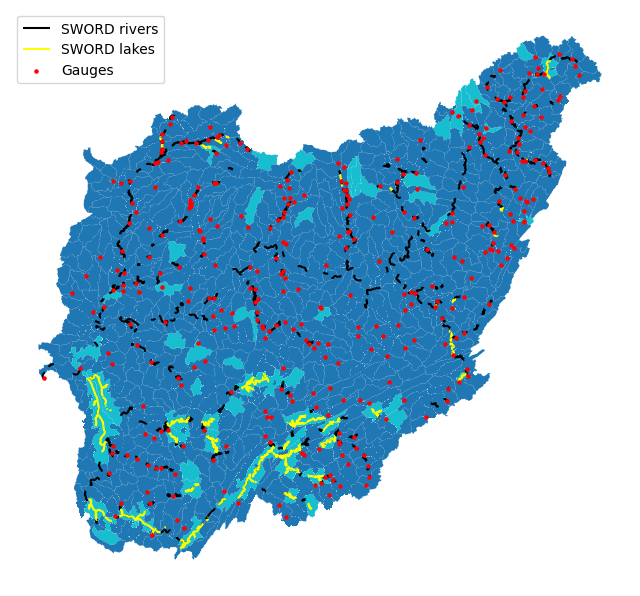

In [17]:
import itertools
lake_ids = list(itertools.chain.from_iterable(matchups_sites['lake_reach_ids']))
basin_sword_l_clean = basin_sword[basin_sword['reach_id'].isin(lake_ids)]

basin_sword_r_clean = basin_sword[basin_sword['reach_id'].isin(matchups_sites['reach_id'])]

plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))


plt.axis('off')
plt.style.use('default')

basins.plot('reservoir', ax=ax, categorical=True)
basin_sword_r_clean.plot(ax=ax, color='black', linewidth=1.5, zorder=9, label="SWORD rivers")
basin_sword_l_clean.plot(ax=ax, color='yellow', linewidth=1.5, zorder=9, label="SWORD lakes")
outlets[outlets['custom']].plot(ax=ax, color='red', markersize=5, zorder=10, label='Gauges')
plt.legend()

fig.savefig(fig_dir / f'matchups_{basin}.png', dpi=300)

In [18]:
# Read in hydroatlas
gdb_path = datasets / "HydroSHEDS" / "HydroATLAS" / "BasinATLAS_v10.gdb"
layer_name = "BasinATLAS_v10_lev12"

hydroatlas = gpd.read_file(gdb_path, layer=layer_name, engine="pyogrio", use_arrow=True)
hydroatlas.replace({'wet_cl_smj':-9999}, 13, inplace=True)
hydroatlas = hydroatlas.set_index('HYBAS_ID')

hydroatlas_filt = hydroatlas[hydroatlas.intersects(matchups.union_all())]

properties = [
    'dis_m3_pyr', # pour point discharge average
    'dis_m3_pmn', # pour point discharge minimum
    'dis_m3_pmx', # pour point discharge maximum
    'run_mm_syr', # subbasin runoff average
    'inu_pc_smn', # subbasin inundation percent minimum
    'inu_pc_smx', # subbasin inundation percent maximum
    'inu_pc_slt', # subbasin inundation percent long-term maximum
    'lka_pc_sse', # subbasin lake area extent (pct)
    'dor_pc_pva', # pour point degree of regulation
    'ria_ha_ssu', # subbasin river area sum
    'riv_tc_ssu', # subbasin river volume sum
    'gwt_cm_sav', # subbasin groundwater table depth average
    'ele_mt_sav', # subbasin elevation average
    'ele_mt_smn', # subbasin elevation minimum
    'ele_mt_smx', # subbasin elevation maximum
    'slp_dg_sav', # subbasin slope average
    'sgr_dk_sav', # subbasin stream gradient average
    'clz_cl_smj', # subbasin climate zone majority
    'cls_cl_smj', # subbasin climate strata majority
    'tmp_dc_syr', # subbasin temperature annual average
    'tmp_dc_smn', # subbasin temperature annual minimum
    'tmp_dc_smx', # subbasin temperature annual maximum
    'tmp_dc_s01', # subbasin temperature monthly average
    'tmp_dc_s02', # subbasin temperature monthly average
    'tmp_dc_s03', # subbasin temperature monthly average
    'tmp_dc_s04', # subbasin temperature monthly average
    'tmp_dc_s05', # subbasin temperature monthly average
    'tmp_dc_s06', # subbasin temperature monthly average
    'tmp_dc_s07', # subbasin temperature monthly average
    'tmp_dc_s08', # subbasin temperature monthly average
    'tmp_dc_s09', # subbasin temperature monthly average
    'tmp_dc_s10', # subbasin temperature monthly average
    'tmp_dc_s11', # subbasin temperature monthly average
    'tmp_dc_s12', # subbasin temperature monthly average
    'pre_mm_syr', # subbasin precipitation annual average
    'pre_mm_s01', # subbasin precipitation monthly average
    'pre_mm_s02', # subbasin precipitation monthly average
    'pre_mm_s03', # subbasin precipitation monthly average
    'pre_mm_s04', # subbasin precipitation monthly average
    'pre_mm_s05', # subbasin precipitation monthly average
    'pre_mm_s06', # subbasin precipitation monthly average
    'pre_mm_s07', # subbasin precipitation monthly average
    'pre_mm_s08', # subbasin precipitation monthly average
    'pre_mm_s09', # subbasin precipitation monthly average
    'pre_mm_s10', # subbasin precipitation monthly average
    'pre_mm_s11', # subbasin precipitation monthly average
    'pre_mm_s12', # subbasin precipitation monthly average
    'pet_mm_syr', # subbasin potential evaporation annual average
    'pet_mm_s01', # subbasin potential evaporation monthly average
    'pet_mm_s03', # subbasin potential evaporation monthly average
    'pet_mm_s04', # subbasin potential evaporation monthly average
    'pet_mm_s02', # subbasin potential evaporation monthly average
    'pet_mm_s05', # subbasin potential evaporation monthly average
    'pet_mm_s06', # subbasin potential evaporation monthly average
    'pet_mm_s07', # subbasin potential evaporation monthly average
    'pet_mm_s08', # subbasin potential evaporation monthly average
    'pet_mm_s09', # subbasin potential evaporation monthly average
    'pet_mm_s10', # subbasin potential evaporation monthly average
    'pet_mm_s11', # subbasin potential evaporation monthly average
    'pet_mm_s12', # subbasin potential evaporation monthly average
    'aet_mm_syr', # subbasin actual evaporation annual average
    'aet_mm_s01', # subbasin actual evaporation monthly average
    'aet_mm_s02', # subbasin actual evaporation monthly average
    'aet_mm_s03', # subbasin actual evaporation monthly average
    'aet_mm_s04', # subbasin actual evaporation monthly average
    'aet_mm_s05', # subbasin actual evaporation monthly average
    'aet_mm_s06', # subbasin actual evaporation monthly average
    'aet_mm_s07', # subbasin actual evaporation monthly average
    'aet_mm_s08', # subbasin actual evaporation monthly average
    'aet_mm_s09', # subbasin actual evaporation monthly average
    'aet_mm_s10', # subbasin actual evaporation monthly average
    'aet_mm_s11', # subbasin actual evaporation monthly average
    'aet_mm_s12', # subbasin actual evaporation monthly average
    'ari_ix_sav', # subbasin aridity index annual average 
    'cmi_ix_syr', # subbasin climate moisture index annual average
    'cmi_ix_s01', # subbasin climate moisture index monthly average
    'cmi_ix_s02', # subbasin climate moisture index monthly average
    'cmi_ix_s03', # subbasin climate moisture index monthly average
    'cmi_ix_s04', # subbasin climate moisture index monthly average
    'cmi_ix_s05', # subbasin climate moisture index monthly average
    'cmi_ix_s06', # subbasin climate moisture index monthly average
    'cmi_ix_s07', # subbasin climate moisture index monthly average
    'cmi_ix_s08', # subbasin climate moisture index monthly average
    'cmi_ix_s09', # subbasin climate moisture index monthly average
    'cmi_ix_s10', # subbasin climate moisture index monthly average
    'cmi_ix_s11', # subbasin climate moisture index monthly average
    'cmi_ix_s12', # subbasin climate moisture index monthly average
    'snw_pc_syr', # subbasin snow cover extent annual average
    'snw_pc_smx', # subbasin snow cover extent annual maximum
    'snw_pc_s01', # subbasin snow cover extent monthly average
    'snw_pc_s02', # subbasin snow cover extent monthly average
    'snw_pc_s03', # subbasin snow cover extent monthly average
    'snw_pc_s04', # subbasin snow cover extent monthly average
    'snw_pc_s05', # subbasin snow cover extent monthly average
    'snw_pc_s06', # subbasin snow cover extent monthly average
    'snw_pc_s07', # subbasin snow cover extent monthly average
    'snw_pc_s08', # subbasin snow cover extent monthly average
    'snw_pc_s09', # subbasin snow cover extent monthly average
    'snw_pc_s10', # subbasin snow cover extent monthly average
    'snw_pc_s11', # subbasin snow cover extent monthly average
    'snw_pc_s12', # subbasin snow cover extent monthly average
    'glc_cl_smj', # subbasin land cover class spatial majority
    'glc_pc_s01', # subbasin land cover percent by class
    'glc_pc_s02', # subbasin land cover percent by class
    'glc_pc_s03', # subbasin land cover percent by class
    'glc_pc_s04', # subbasin land cover percent by class
    'glc_pc_s05', # subbasin land cover percent by class
    'glc_pc_s06', # subbasin land cover percent by class
    'glc_pc_s07', # subbasin land cover percent by class
    'glc_pc_s08', # subbasin land cover percent by class
    'glc_pc_s09', # subbasin land cover percent by class
    'glc_pc_s10', # subbasin land cover percent by class
    'glc_pc_s11', # subbasin land cover percent by class
    'glc_pc_s12', # subbasin land cover percent by class
    'glc_pc_s13', # subbasin land cover percent by class
    'glc_pc_s14', # subbasin land cover percent by class
    'glc_pc_s15', # subbasin land cover percent by class
    'glc_pc_s16', # subbasin land cover percent by class
    'glc_pc_s17', # subbasin land cover percent by class
    'glc_pc_s18', # subbasin land cover percent by class
    'glc_pc_s19', # subbasin land cover percent by class
    'glc_pc_s20', # subbasin land cover percent by class
    'glc_pc_s21', # subbasin land cover percent by class
    'glc_pc_s22', # subbasin land cover percent by class
    'pnv_cl_smj', # subbasin potential natural vegetation class spatial majority
    'pnv_pc_s01', # subbasin potential natural vegetation percent by class
    'pnv_pc_s02', # subbasin potential natural vegetation percent by class
    'pnv_pc_s03', # subbasin potential natural vegetation percent by class
    'pnv_pc_s04', # subbasin potential natural vegetation percent by class
    'pnv_pc_s05', # subbasin potential natural vegetation percent by class
    'pnv_pc_s06', # subbasin potential natural vegetation percent by class
    'pnv_pc_s07', # subbasin potential natural vegetation percent by class
    'pnv_pc_s08', # subbasin potential natural vegetation percent by class
    'pnv_pc_s09', # subbasin potential natural vegetation percent by class
    'pnv_pc_s10', # subbasin potential natural vegetation percent by class
    'pnv_pc_s11', # subbasin potential natural vegetation percent by class
    'pnv_pc_s12', # subbasin potential natural vegetation percent by class
    'pnv_pc_s13', # subbasin potential natural vegetation percent by class
    'pnv_pc_s14', # subbasin potential natural vegetation percent by class
    'pnv_pc_s15', # subbasin potential natural vegetation percent by class
    'wet_cl_smj', # subbasin wetland class spatial majority
    'wet_pc_sg1', # subbasin wetland class percent by class group
    'wet_pc_sg2', # subbasin wetland class percent by class group
    'wet_pc_s01', # subbasin wetland class percent by class
    'wet_pc_s02', # subbasin wetland class percent by class
    'wet_pc_s03', # subbasin wetland class percent by class
    'wet_pc_s04', # subbasin wetland class percent by class
    'wet_pc_s05', # subbasin wetland class percent by class
    'wet_pc_s06', # subbasin wetland class percent by class
    'wet_pc_s07', # subbasin wetland class percent by class
    'wet_pc_s08', # subbasin wetland class percent by class
    'wet_pc_s09', # subbasin wetland class percent by class
    'for_pc_sse', # subbasin forest cover extent
    'crp_pc_sse', # subbasin cropland area extent
    'pst_pc_sse', # subbasin pasture area extent
    'ire_pc_sse', # subbasin irrigated area extent
    'gla_pc_sse', # subbasin glaciated area extent
    'prm_pc_sse', # subbasin permafrost area extent
    'pac_pc_sse', # subbasin protected area extent
    'tbi_cl_smj', # subbasin terrestrial biome class spatial majority
    'tec_cl_smj', # subbasin terrestrial ecoregions class spatial majority
    'fmh_cl_smj', # subbasin freshwater major habitat class spatial majority
    'fec_cl_smj', # subbasin freshwater ecoregions class spatial majority
    'cly_pc_sav', # subbasin clay fraction average
    'slt_pc_sav', # subbasin silt fraction average
    'snd_pc_sav', # subbasin sand fraction average
    'soc_th_sav', # subbasin soil organic carbon average
    'swc_pc_syr', # subbasin soil water content annual average
    'swc_pc_s01', # subbasin soil water content monthly average
    'swc_pc_s02', # subbasin soil water content monthly average
    'swc_pc_s03', # subbasin soil water content monthly average
    'swc_pc_s04', # subbasin soil water content monthly average
    'swc_pc_s05', # subbasin soil water content monthly average
    'swc_pc_s06', # subbasin soil water content monthly average
    'swc_pc_s07', # subbasin soil water content monthly average
    'swc_pc_s08', # subbasin soil water content monthly average
    'swc_pc_s09', # subbasin soil water content monthly average
    'swc_pc_s10', # subbasin soil water content monthly average
    'swc_pc_s11', # subbasin soil water content monthly average
    'swc_pc_s12', # subbasin soil water content monthly average
    'lit_cl_smj', # subbasin lithologic class spatial majority
    'kar_pc_sse', # subbasin karst area extent
    'ero_kh_sav', # subbasin soil erosion annual average
    'pop_ct_ssu', # subbasin population count
    'ppd_pk_sav', # subbasin population density average
    'urb_pc_sse', # subbasin urban area extent
    'nli_ix_sav', # subbasin nighttime lights average 
    'rdd_mk_sav', # subbasin road density average
    'hft_ix_s93', # subbasin human footprint 1993
    'hft_ix_s09', # subbasin human footprint 2009
    'gad_id_smj', # subbasin global adminimumistrative area majority
    'gdp_ud_sav', # subbasin gross domestic product average
    'gdp_ud_ssu', # subbasin gross domestic product sum
    'hdi_ix_sav', # subbasin human development index average
]

/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pyogrio/raw.py:337: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  table = reader.read_all()


In [22]:
outlets_buff = outlets.to_crs("EPSG:6933")
outlets_buff.geometry = outlets_buff.buffer(50000)

hybas_pairs = gpd.sjoin(
    outlets_buff,
    hydroatlas_filt.to_crs("EPSG:6933"),
    how='left',
)

hybas_area = hybas_pairs['UP_AREA']
merit_area = hybas_pairs['total_area']
hybas_pairs['hybas_area_diff'] = (hybas_area - merit_area) / ((hybas_area + merit_area)/2)

def get_best_hybas(grp):
     # Pick best match by area.
    idx_min = grp['hybas_area_diff'].abs().idxmin()
    return grp.loc[idx_min]

all_attributes = hybas_pairs.reset_index().groupby('comid').apply(get_best_hybas, include_groups=False)

In [39]:
matchup_props = ['unitarea','reservoir','total_area','strahler_order', 'shreve_order']
all_props = matchup_props + properties + ['hybas_area_diff']
attributes = all_attributes[all_props]

attributes.index.name = 'index'
attributes.to_csv(attributes_dir / f"{basin}_attributes.csv", index=True)

In [40]:
final_matchups = matchups_sites.merge(attributes[properties + ['hybas_area_diff']], left_index=True, right_index=True)
final_matchups.to_file(metadata_dir / f'{basin}_matchups.gpkg',
    layer="matchups", # gpkg requires a layer name
    driver="GPKG"
)

In [41]:
test = gpd.read_file(
    metadata_dir / f"{basin}_matchups.gpkg",
    layer="matchups"
)
test

,comid,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,...,nli_ix_sav,rdd_mk_sav,hft_ix_s93,hft_ix_s09,gad_id_smj,gdp_ud_sav,gdp_ud_ssu,hdi_ix_sav,hybas_area_diff,geometry
0,74024610,POINT (-78.8742 41.77),4837.3,674.0,False,False,7.426990e+10,4519.811622,0.0,[],...,493,189,83,83,240,57173,2.781980e+07,947,0.006162,"MULTIPOLYGON (((-78.87292 41.76875, -78.87292 ..."
1,74024620,POINT (-78.6258 41.9842),3738.3,715.2,False,False,7.426990e+10,3764.503644,0.0,[],...,949,580,128,142,240,63747,4.529935e+07,952,0.016922,"MULTIPOLYGON (((-78.59792 41.86125, -78.59708 ..."
2,74024945,POINT (-78.3933 41.9758),2262.2,725.1,False,False,NaN,NaN,NaN,[],...,2121,576,170,189,240,63747,4.133564e+07,952,-0.018155,"MULTIPOLYGON (((-78.15292 41.88125, -78.15292 ..."
3,74025163,POINT (-79.1067 42.13),892.3,892.1,False,False,NaN,NaN,NaN,[],...,3404,1454,220,252,240,63747,5.959453e+07,952,0.001344,"MULTIPOLYGON (((-79.20958 42.28458, -79.21125 ..."
4,74025192,POINT (-79.1817 42.1308),1010.5,500.4,False,False,NaN,NaN,NaN,[],...,3404,1454,220,252,240,63747,5.959453e+07,952,-0.122899,"MULTIPOLYGON (((-79.15875 42.15042, -79.15792 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,USGS-03601990,POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],...,1460,185,157,129,240,45808,2.195454e+08,810,-0.003237,"MULTIPOLYGON (((-87.47708 35.52208, -87.47958 ..."
1053,USGS-03603000,POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],...,307,172,55,56,240,45808,1.265268e+06,810,0.012538,"MULTIPOLYGON (((-87.74375 35.92292, -87.74375 ..."
1054,USGS-03604000,POINT (-87.8333 35.4958),1156.4,538.5,False,True,7.426220e+10,1106.467116,0.0,[],...,97,116,50,59,240,45808,2.722651e+07,810,0.075553,"MULTIPOLYGON (((-87.80958 35.41458, -87.81042 ..."
1055,USGS-03604400,POINT (-87.7783 35.8125),1874.8,718.4,False,True,7.426220e+10,1673.902810,0.0,[],...,766,175,70,62,240,45808,7.516671e+07,810,0.052055,"MULTIPOLYGON (((-87.83625 35.72792, -87.83625 ..."


In [ ]:
test['mb_values']

In [ ]:
test.plot('hybas_area_diff')